In [53]:
import numpy as np

In [54]:
class _LinearRegression():
    def __init__(self, alpha=0.01, max_iters=100, max_weight_dist = 1e-4, method="gradient descent"):
        self.alpha = alpha
        self.max_iters = max_iters
        self.max_weight_dist = max_weight_dist
        self.method = method
        self.params = None
        self.iters = 0
        self.errors = []
        
        
    def _mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)

    
    def _gradient_descent(self, X_train, y_train, n_samples):
        weight_dist = np.inf
        
        while weight_dist > self.max_weight_dist and self.iters < self.max_iters:
            old_params = self.params
            
            self.params = old_params - (self.alpha/n_samples) * X_train.T @ (X_train @ self.params - y_train)
            weight_dist = np.linalg.norm(old_params - self.params)
            
            self.errors.append(self._mse(y_train, X_train @ self.params))
            self.iters += 1
        
        return self
            
    
    def _sgd(self, X_train, y_train, n_samples, n_features):
        np.random.seed(42)
        weight_dist = np.inf
        
        while weight_dist > self.max_weight_dist and self.iters < self.max_iters:
            ind = np.random.randint(n_samples)
            x = np.reshape(X_train[ind], (1, n_features))
            old_params = self.params
            
            self.params = old_params - (self.alpha/n_samples) * x.T @ (x @ self.params - y_train[ind])
            weight_dist = np.linalg.norm(old_params - self.params)
            
            self.errors.append(self._mse(y_train, X_train @ self.params))
            self.iters += 1
            
        return self
    
    
    def _fit(self, X_train, y_train):
        n_samples, n_features = X_train.shape
        y_train = y_train[:, np.newaxis]
        self.params = np.zeros((n_features, 1))
        
        if self.method == "gradient descent":
            return self._gradient_descent(X_train, y_train, n_samples)
                       
        elif self.method == "sgd":
            return self._sgd(X_train, y_train, n_samples, n_features)
                       
        else: 
            raise ValueError(f"No such method: '{self.method}'")
        

    def _predict(self, X_test):
        return X_test @ self.params

In [55]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target

data.shape       

(506, 13)

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (354, 13)
Test data shape: (152, 13)


In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [58]:
from sklearn.metrics import mean_squared_error

In [59]:
X_train_transformed_ones = np.hstack((np.ones((X_train.shape[0], 1)), X_train_transformed))
X_test_transformed_ones = np.hstack((np.ones((X_test.shape[0], 1)), X_test_transformed))

X_train_transformed_ones.shape

(354, 14)

In [60]:
%%time

_lr_custom = _LinearRegression(max_iters=1e4)
_lr_custom._fit(X_train_transformed_ones, y_train)
y_pred_custom = _lr_custom._predict(X_test_transformed_ones)
mse_custom = mean_squared_error(y_test, y_pred_custom)

print(f"Mean squared error for custom model: {mse_custom}")

Mean squared error for custom model: 41.90183095030527
Wall time: 563 ms


Number of iterations: 4548


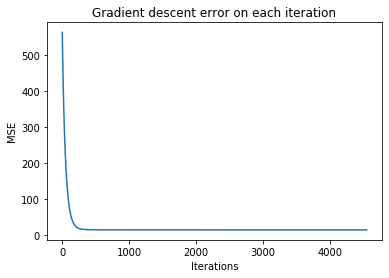

In [61]:
import matplotlib.pyplot as plt

iterations = range(_lr_custom.iters)
errors = _lr_custom.errors
print(f'Number of iterations: {_lr_custom.iters}')

plt.plot(iterations, errors)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Gradient descent error on each iteration");

In [62]:
%%time

from sklearn.linear_model import LinearRegression

y_pred_sklearn = LinearRegression().fit(X_train_transformed, y_train).predict(X_test_transformed)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

print(f"Mean squared error for sklearn model: {mse_sklearn}")

Mean squared error for sklearn model: 41.836188699269066
Wall time: 52.6 ms


### Testing SGD

In [63]:
%%time

_sgd_custom = _LinearRegression(method="sgd", max_iters=1e5, max_weight_dist=1e-8)
_sgd_custom._fit(X_train_transformed_ones, y_train)
y_pred_custom = _sgd_custom._predict(X_test_transformed_ones)
mse_custom = mean_squared_error(y_test, y_pred_custom)

print(f"MSE for custom SGD: {mse_custom}")

MSE for custom SGD: 61.63348429044729
Wall time: 6.38 s


Number of iterations: 69606


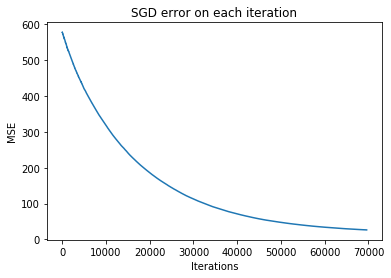

In [64]:
iterations = range(_sgd_custom.iters)
errors = _sgd_custom.errors
print(f"Number of iterations: {_sgd_custom.iters}")

plt.plot(iterations, errors)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("SGD error on each iteration");

In [65]:
%%time

from sklearn.linear_model import SGDRegressor

y_pred_sklearn = SGDRegressor().fit(X_train_transformed, y_train).predict(X_test_transformed)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

print(f"Mean squared error for sklearn SGD: {mse_sklearn}")

Mean squared error for sklearn SGD: 42.18497309707079
Wall time: 17.6 ms
